In [ ]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from time import mktime
from google.colab import  drive
from IPython.display import HTML, display
#Helpers

#Progress bar helper
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

#Cartesian Coordinates relative to earth, conversion implemented from http://faraday.uwyo.edu/~admyers/ASTR5160/handouts/51605.pdf
def convert_cartesian(ra, decl, dist):
  x = dist * np.cos(ra) * np.cos(decl)
  y = dist * np.sin(ra) * np.cos(decl)
  z = dist * np.sin(decl)
  return x.to_numpy(), y.to_numpy(), z.to_numpy()
#Inverse of Cartesian coordinate function, returns cartesian coordinates to ephemeri, RA/DECL/DIST, returns radians or degrees
def convert_ephemeri(x, y , z , radian = True):
  dist = np.sqrt(x**2 + y**2 + z**2)
  ra = np.arctan2(y,x)
  decl = np.arcsin(z/dist)
  #TODO: Finish this
  if radian:
    return ra, decl, dist
  else:
    return math.degrees(ra), math.degrees(decl), dist

def find_cycle(data, time_delta = 20): #returns array of time points where "cycle" occurs
  time = []
  max_val = -1* np.inf
  for i in range(len(data)):
    if data['Right Ascension'][i] > max_val:
      max_val = data['Right Ascension'][i]
    elif ((max_val - data['Right Ascension'][i]) > 300):
      if len(time) == 0:
        max_val = data['Right Ascension'][i]
        time.append(data['Time'][i])
      elif (len(time) > 0) & (data['Time'][i] - time[len(time) - 1] > timedelta(days = time_delta)):
        max_val = data['Right Ascension'][i]
        time.append(data['Time'][i])
  return time

def convert_time(data, normalize = True): #converts time from datetime to epoch, normalize will start at 0
  datacopy = data.copy()
  datacopy['Time'] = datacopy['Time'].apply(lambda x: mktime(x.timetuple()))
  if normalize:
    datacopy['Time'] = datacopy['Time'] - datacopy['Time'][0] #normalize to start time
  return datacopy

def decycle_ra(data, cycles): #adds back 360 at every cycle occurence to make data continuous
  datacopy = data.copy()
  ras = []
  prev_val = data['Right Ascension'][0] #Keeping track of times where the data bobs up and down near 360 degrees, causing false "readditions"
  for i in range(len(data)):
    c = 0
    for t in cycles:
      if data['Time'][i] >= t:
        c += 1
    if data['Right Ascension'][i] - prev_val > 300: #Makes sure we don't add back too many periods
      c -= 1
    else:
      prev_val = data['Right Ascension'][i]
    ra = data['Right Ascension'][i] + 360 * c
    ras.append(ra)
  datacopy['Right Ascension'] = ras
  return datacopy

def fourier_featurize(X, d = 5, freq = 1):
  data = []
  for i in range(d):
    if i == 0:
      data.append(np.cos(i * freq * X).reshape(1,-1)[0])
    else:
      data.append(np.sin(i * freq * X).reshape(1,-1)[0])
      data.append(np.cos(i * freq * X).reshape(1,-1)[0])
  return np.array(data).T

class transformed_fourier_nn:
  plots = ['t', '3d', 'ra'] # t = transformed, 3d = 3d ephemeri, ra = original rate of ascension data
  def __init__(self, time_delta = 20, hidden_layers = (5, 5), activation = 'relu', max_iter = 50000, tol = 1e-6):
    self.hidden_layers = hidden_layers
    self.activation = activation
    self.max_iter = max_iter
    self.tol = tol
    self.cycles = np.array([])
    self.reg = None
    self.best_fit = None
    self.time_delta = time_delta
  def transform_data(self, data, normalize = True, fit = True): #does all necessary data transformations
    if fit:
      self.ogdata = data
  
    cycle = find_cycle(data, self.time_delta)
    for i in cycle:
      if i not in self.cycles:
        self.cycles = np.append(self.cycles, i)
    data = decycle_ra(data, self.cycles)
    data = convert_time(data, normalize)
    if not normalize:
      data['Time'] = data['Time'] - convert_time(self.ogdata.iloc[[0]], normalize = False)['Time'][0]
    X = np.array(data['Time']).reshape(-1,1)
    Y = np.array(data['Right Ascension'])

    if (fit) & (self.reg is None):
      self.reg = LinearRegression().fit(X, Y)
      y_hat = self.reg.predict(X)
    else:
      y_hat = self.reg.predict(X)
    Y = Y - y_hat
    return X, Y
  def fit(self, data, plot = None, d = 5, freq = 0.0000002, silent = False):
    if plot not in transformed_fourier_nn.plots and plot is not None:
      return print("Specified plot type not valid, use 't', '3d', or 'ra'.")
    self.d = d
    self.freq = freq
    X, Y = self.transform_data(data)
    fourier_features = fourier_featurize(X, d, freq)
    self.fourier_nn = MLPRegressor(hidden_layer_sizes=self.hidden_layers, activation=self.activation,max_iter = self.max_iter,tol=self.tol).fit(fourier_features, Y)
    y_hat = self.fourier_nn.predict(fourier_features)
    mse = np.mean((Y - y_hat)**2)
    if plot == 't':
      plt.plot(X, y_hat, zorder=2.5)
      plt.plot(X, Y)
      plt.legend(['Predicted','True'])
      plt.show()
    elif plot == 'ra':
      best_fit = self.reg.predict(X)
      plt.plot(X, y_hat + best_fit, zorder=2.5)
      plt.plot(X, Y + best_fit)
      plt.legend(['Predicted','True'])
      plt.show()
    elif plot == '3d':
      best_fit = self.reg.predict(X)
      pred = np.mod(y_hat + best_fit, 360)

      x1, y1, z1 = convert_cartesian(np.radians(pred), np.radians(data['Declination']), data['Distance'])

      x2, y2, z2 = convert_cartesian(np.radians(data['Right Ascension']), np.radians(data['Declination']), data['Distance'])

      fig = plt.figure()
      ax = fig.gca(projection='3d')
      ax.plot(x1, y1, z1)
      ax.plot(x2, y2, z2)
      plt.legend(['Predicted', 'Truth'])
      plt.show()
    if not silent:
      return mse
    else:
      return self
  def predict(self, data, plot = None, return_val = False):
    if plot not in transformed_fourier_nn.plots and plot is not None:
      return print("Specified plot type not valid, use 't', '3d', or 'ra'.")
    if self.reg is None:
      return print("Must fit data first")
    X, Y = self.transform_data(data, normalize = False, fit = False)
    fourier_features = fourier_featurize(X, self.d, self.freq)
    y_hat = self.fourier_nn.predict(fourier_features)
    best_fit = self.reg.predict(X)
    pred = np.mod(y_hat + best_fit, 360)
    mse = np.mean((Y - y_hat)**2)
    if plot == 't':
      plt.plot(X, y_hat, zorder=2.5)
      plt.plot(X, Y)
      plt.legend(['Predicted','True'])
      plt.show()
    elif plot == 'ra':
      best_fit = self.reg.predict(X)
      plt.plot(X, y_hat + best_fit, zorder=2.5)
      plt.plot(X, Y + best_fit)
      plt.legend(['Predicted','True'])
      plt.show()
    elif plot == '3d':
      x1, y1, z1 = convert_cartesian(np.radians(pred), np.radians(data['Declination']), data['Distance'])

      x2, y2, z2 = convert_cartesian(np.radians(data['Right Ascension']), np.radians(data['Declination']), data['Distance'])

      fig = plt.figure()
      ax = fig.gca(projection='3d')
      ax.plot(x1, y1, z1)
      ax.plot(x2, y2, z2)
      plt.legend(['Predicted', 'Truth'])
      plt.show()
    if return_val:
      return pred, mse
    else:
      return mse

class fourier_nn:
  plots = ['d','3d'] # t = transformed, 3d = 3d ephemeri, ra = original rate of ascension data
  def __init__(self, hidden_layers = (5, 5), activation = 'relu', max_iter = 50000, tol = 1e-6):
    self.hidden_layers = hidden_layers
    self.activation = activation
    self.max_iter = max_iter
    self.tol = tol
  def transform_data(self, data, normalize = True, fit = True): #does all necessary data transformations
    if fit:
      self.ogdata = data
    data = convert_time(data, normalize)
    if not normalize:
      data['Time'] = data['Time'] - convert_time(self.ogdata.iloc[[0]], normalize = False)['Time'][0]
    X = np.array(data['Time']).reshape(-1,1)
    Y = np.array(data['Declination'])
    return X, Y
  def fit(self, data, plot = None, d = 5, freq = 0.0000002, silent = False):
    if plot not in fourier_nn.plots and plot is not None:
      return print("Specified plot type not valid, use 'd', '3d'.")
    self.d = d
    self.freq = freq
    X, Y = self.transform_data(data)
    fourier_features = fourier_featurize(X, d, freq)
    self.fourier_nn = MLPRegressor(hidden_layer_sizes=self.hidden_layers, activation=self.activation,max_iter = self.max_iter,tol=self.tol).fit(fourier_features, Y)
    y_hat = self.fourier_nn.predict(fourier_features)
    mse = np.mean((Y - y_hat)**2)
    if plot == 'd':
      plt.plot(X, y_hat, zorder=2.5)
      plt.plot(X, Y)
      plt.legend(['Predicted','True'])
      plt.show()
    elif plot == '3d':
      x1, y1, z1 = convert_cartesian(np.radians(data['Right Ascension']), np.radians(y_hat), data['Distance'])

      x2, y2, z2 = convert_cartesian(np.radians(data['Right Ascension']), np.radians(data['Declination']), data['Distance'])

      fig = plt.figure()
      ax = fig.gca(projection='3d')
      ax.plot(x1, y1, z1)
      ax.plot(x2, y2, z2)
      plt.legend(['Predicted', 'Truth'])
      plt.show()
    if not silent:
      return mse
    else:
      return self
  def predict(self, data, plot = None, return_val = False):
    if plot not in fourier_nn.plots and plot is not None:
      return print("Specified plot type not valid, use 'd', '3d'.")
    X, Y = self.transform_data(data, normalize = False, fit = False)
    fourier_features = fourier_featurize(X, self.d, self.freq)
    y_hat = self.fourier_nn.predict(fourier_features)
    mse = np.mean((Y - y_hat)**2)
    if plot == 'd':
      plt.plot(X, y_hat, zorder=2.5)
      plt.plot(X, Y)
      plt.legend(['Predicted','True'])
      plt.show()
    elif plot == '3d':
      x1, y1, z1 = convert_cartesian(np.radians(data['Right Ascension']), np.radians(y_hat), data['Distance'])

      x2, y2, z2 = convert_cartesian(np.radians(data['Right Ascension']), np.radians(data['Declination']), data['Distance'])

      fig = plt.figure()
      ax = fig.gca(projection='3d')
      ax.plot(x1, y1, z1)
      ax.plot(x2, y2, z2)
      plt.legend(['Predicted', 'Truth'])
      plt.show()
    if return_val:
      return y_hat, mse
    else:
      return mse

def hyperparameter_tune(freqs, ds, data, validation, time_delta = 20, declination = False):
  periods = len(freqs) * len(ds)
  errors = []
  i = 0
  out = display(progress(0, periods), display_id=True)
  for f in freqs:
    error = np.array([])
    for d in ds:
      i += 1
      if declination:
        model = fourier_nn().fit(data, d = d, freq = f, silent = True)
      else:
        model = transformed_fourier_nn(time_delta = time_delta).fit(data, d = d, freq = f, silent = True)
      mse = model.predict(validation)
      error  = np.append(error, mse)
      out.update(progress(i, periods))
    errors.append(error)
  i1, i2 = np.unravel_index(np.nanargmin(errors, axis=None), np.array(errors).shape)
  return freqs[i1], ds[i2]

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
#read in generated data
parse_dates = ['Time']
mercury = pd.read_csv("../../Data/Mercury2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)
venus = pd.read_csv("../../Data/Venus2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)
mars = pd.read_csv("../../Data/Mars2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)
jupiter = pd.read_csv("../../Data/Jupiter2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)
saturn = pd.read_csv("../../Data/Saturn2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)
uranus = pd.read_csv("../../Data/Uranus2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)
neptune = pd.read_csv("/../../Data/Neptune2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)

moon = pd.read_csv("../../Data/Moon2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)
sun = pd.read_csv("../../Data/Sun2x.csv", index_col=0, parse_dates=parse_dates, date_parser = pd.to_datetime)

train = 0.75
val = 0.8

mer_total_train_data = mercury[0:int(train * len(mercury))]
mer_data = mer_total_train_data[0: int(val * len(mer_total_train_data))]
mer_validation = mer_total_train_data[int(val * len(mer_total_train_data)):].reset_index()

ven_total_train_data = venus[0:int(train * len(venus))]
ven_data = ven_total_train_data[0: int(val * len(ven_total_train_data))]
ven_validation = ven_total_train_data[int(val * len(ven_total_train_data)):].reset_index()

mars_total_train_data = mars[0:int(train * len(mars))]
mars_data = mars_total_train_data[0: int(val * len(mars_total_train_data))]
mars_validation = mars_total_train_data[int(val * len(mars_total_train_data)):].reset_index()

jup_total_train_data = jupiter[0:int(train * len(jupiter))]
jup_data = jup_total_train_data[0: int(val * len(jup_total_train_data))]
jup_validation = jup_total_train_data[int(val * len(jup_total_train_data)):].reset_index()

sat_total_train_data = saturn[0:int(train * len(saturn))]
sat_data = sat_total_train_data[0: int(val * len(sat_total_train_data))]
sat_validation = sat_total_train_data[int(val * len(sat_total_train_data)):].reset_index()

ura_total_train_data = uranus[0:int(train * len(uranus))]
ura_data = ura_total_train_data[0: int(val * len(ura_total_train_data))]
ura_validation = ura_total_train_data[int(val * len(ura_total_train_data)):].reset_index()

nep_total_train_data = neptune[0:int(train * len(neptune))]
nep_data = nep_total_train_data[0: int(val * len(nep_total_train_data))]
nep_validation = nep_total_train_data[int(val * len(nep_total_train_data)):].reset_index()

moon_total_train_data = moon[0:int(train * len(moon))]
moon_data = moon_total_train_data[0: int(val * len(moon_total_train_data))]
moon_validation = moon_total_train_data[int(val * len(moon_total_train_data)):].reset_index()

sun_total_train_data = sun[0:int(train * len(sun))]
sun_data = sun_total_train_data[0: int(val * len(sun_total_train_data))]
sun_validation = sun_total_train_data[int(val * len(sun_total_train_data)):].reset_index()

#Empirical Regression Vs. MLP:
testing multi-layer perceptron model (MLP) vs Regression on a sum of sines similar to RA data

In [ ]:
def NN_prediction(X_train,y_train,X_test,y_test,hidden_layers,activation,max_iter = 50000,tol = 1e-6):
    
    model = MLPRegressor(hidden_layer_sizes=hidden_layers, activation=activation,max_iter = max_iter,tol=tol).fit(X_train, y_train)
    
    #MSE for training data
    prediction_train = model.predict(X_train)  
    MSE_train = mean_squared_error(prediction_train,y_train)
    
    #MSE for test data
    prediction_test = model.predict(X_test)
    MSE_test = mean_squared_error(prediction_test,y_test)
    
    return prediction_train, prediction_test, MSE_train, MSE_test

def reset_time(Time,num_cycles = 1):
    cycle = (Time.shape[0]/num_cycles)
    New_time = list(range(0,Time.shape[0]))
    mod_time = np.array(New_time).astype(int) % cycle
    return mod_time


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Regression


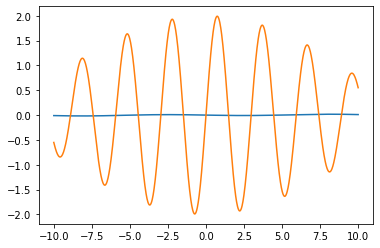

NN


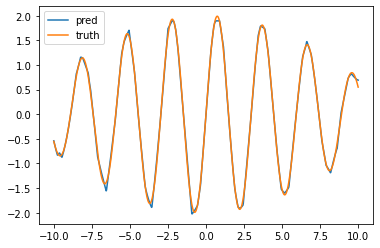

VALIDATION:
Regression


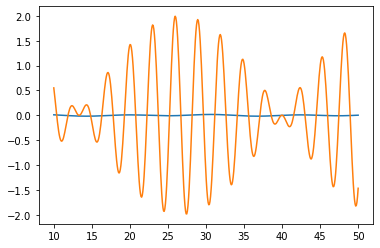

NN


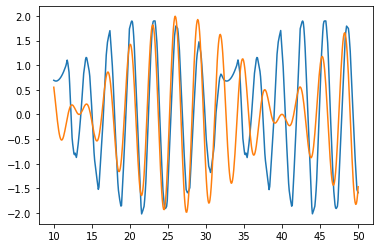

In [ ]:
m = 5
d = 3

X = np.linspace(-10,10, 1000).reshape(-1,1)
Y = np.sin(np.sqrt(m)*X) + np.sin(2 * X)
f = 0.28

X1 = fourier_featurize(X, d, f)
X_test = np.linspace(10, 50, 500).reshape(-1,1)
Y_test = np.sin(np.sqrt(m)*X_test) + np.sin(2 * X_test)
X2 = fourier_featurize(X_test, d, f)
pred_train, pred_test, mse_train, mse_test = NN_prediction(X1, Y, X2 , Y_test, (10, 10), 'relu')
reg = LinearRegression().fit(X1, Y)
reg_predict = reg.predict(X1)
reg_predict_test = reg.predict(X2)
print('Regression')
plt.plot(X, reg_predict)
plt.plot(X, Y)
plt.show()
print('NN')
plt.plot(X, pred_train)
plt.plot(X, Y)
plt.legend(['pred', 'truth'])
plt.show()
print('VALIDATION:')
print('Regression')
plt.plot(X_test, reg_predict_test)
plt.plot(X_test, Y_test)
plt.show()
print('NN')
plt.plot(X_test, pred_test)
plt.plot(X_test, Y_test)
plt.show()

# Fourier Feature MLP:
implementing our fourier feature model for RA/DECL but now using the multi-layer perceptron architecture instead of simple linear regression.

## Training:

### Mercury:

In [ ]:
#freqs = np.array([2.0904522613065327e-07])
#ds = np.linspace(2, 15, 14, dtype = int)

#hyperparameter_tune(freqs, ds, mer_data, mer_validation)

(2.0904522613065327e-07, 11)

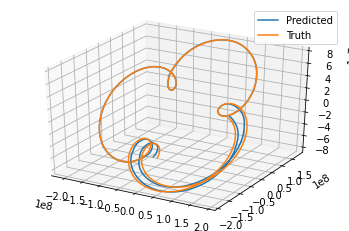

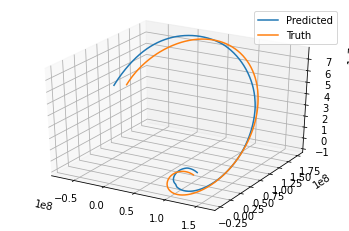

67.90578698224678

In [ ]:
opt_mer_model = transformed_fourier_nn().fit(mer_data, d = 10, freq = 2.0904522613065327e-07, silent = True)
opt_mer_model.predict(mer_data, plot = '3d')
opt_mer_model.predict(mer_validation, plot = '3d')

In [ ]:
#freqs = np.array([2.0521052631578947e-07])
#ds = np.linspace(2, 15, 14, dtype = int)

#hyperparameter_tune(freqs, ds, mer_data, mer_validation, declination = True)

(2.0521052631578947e-07, 3)

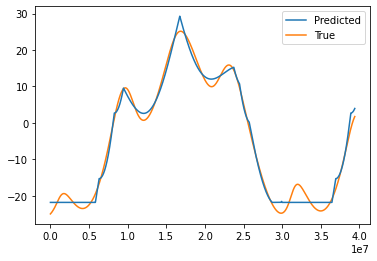

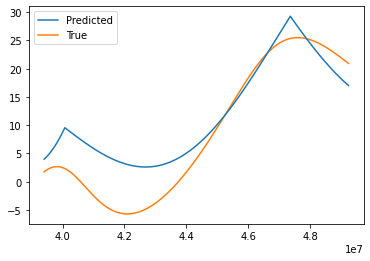

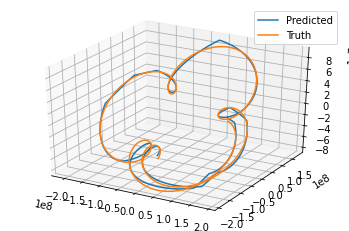

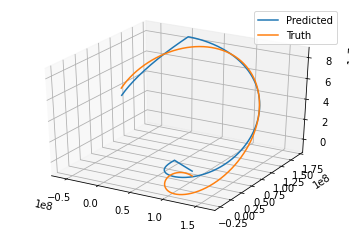

25.666072002081858

In [ ]:
optd_mer_model = fourier_nn(activation='relu').fit(mer_data, d = 3, freq = 2.0521052631578947e-07, silent = True, plot = 'd')
optd_mer_model.predict(mer_validation, plot = 'd')
optd_mer_model.predict(mer_data, plot = '3d')
optd_mer_model.predict(mer_validation, plot = '3d')

### Venus:

In [ ]:
#freqs = np.array([3.1126315789473685e-08])
#ds = np.linspace(2, 15, 14, dtype=int)

#hyperparameter_tune(freqs, ds, ven_data, ven_validation, time_delta = 200)

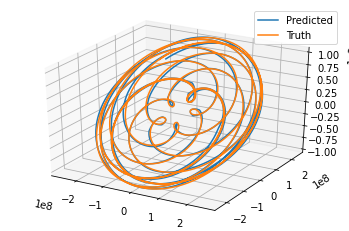

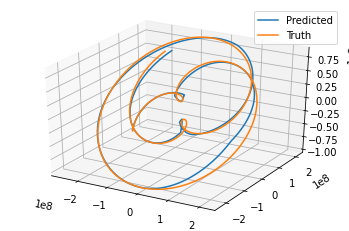

47.04702674830557

In [ ]:
opt_ven_model = transformed_fourier_nn(time_delta = 200)
opt_ven_model.fit(ven_data, d = 3, freq = 3.1126315789473685e-08, plot = '3d')
opt_ven_model.predict(ven_validation, plot = '3d')

In [ ]:
#freqs = np.array([1.99e-07])
#ds = np.linspace(2, 15, 14, dtype = int)

#hyperparameter_tune(freqs, ds, ven_data, ven_validation, declination = True)

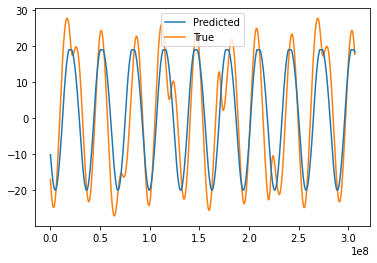

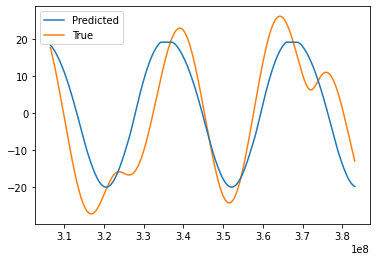

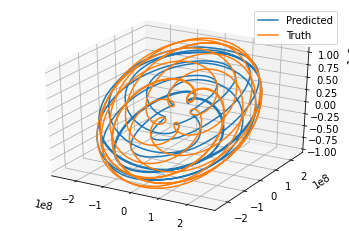

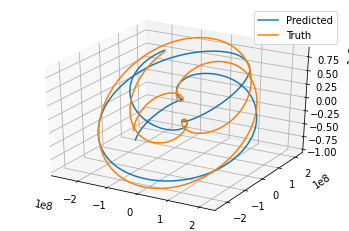

96.29760703474075

In [ ]:
optd_ven_model = fourier_nn().fit(ven_data, d = 3, freq = 1.99e-07, silent = True, plot = 'd')
optd_ven_model.predict(ven_validation, plot = 'd')
optd_ven_model.predict(ven_data, plot = '3d')
optd_ven_model.predict(ven_validation, plot = '3d')

### Mars:

In [ ]:
#freqs = np.array([9.32e-08])
#ds = np.linspace(2, 15, 14, dtype=int)

#hyperparameter_tune(freqs, ds, mars_data, mars_validation)

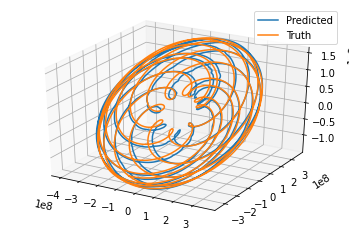

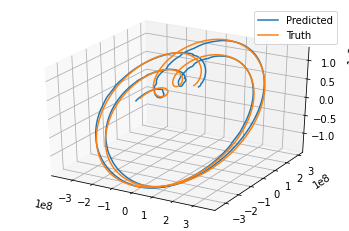

51.185895250422845

In [ ]:
opt_mars_model = transformed_fourier_nn()
opt_mars_model.fit(mars_data, d = 14, freq = 9.32e-08, plot = '3d')
opt_mars_model.predict(mars_validation, plot = '3d')

In [ ]:
#freqs = np.array([1.51e-08])
#ds = np.linspace(2, 15, 14, dtype = int)

#hyperparameter_tune(freqs, ds, mars_data, mars_validation, declination = True)

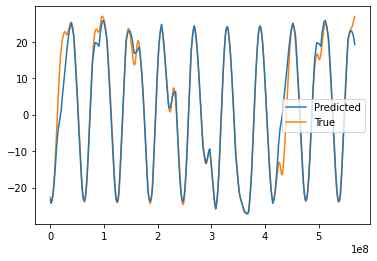

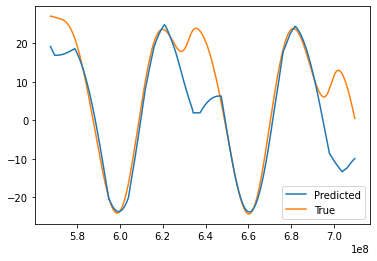

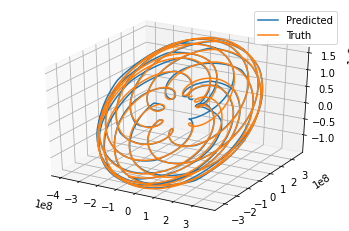

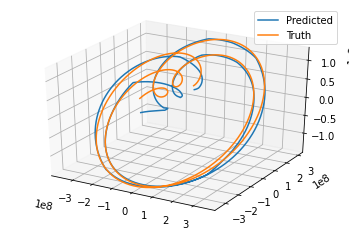

77.32574698264553

In [ ]:
optd_mars_model = fourier_nn().fit(mars_data, d =10, freq = 1.519e-08, silent = True, plot = 'd')
optd_mars_model.predict(mars_validation, plot = 'd')
optd_mars_model.predict(mars_data, plot = '3d')
optd_mars_model.predict(mars_validation, plot = '3d')

### Jupiter:

In [ ]:
#freqs = np.array([9.110526315789473e-08])
#ds = np.linspace(2, 15, 14, dtype=int)

#hyperparameter_tune(freqs, ds, jup_data, jup_validation, time_delta = 800)

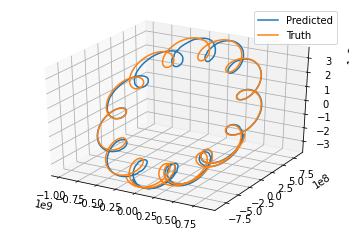

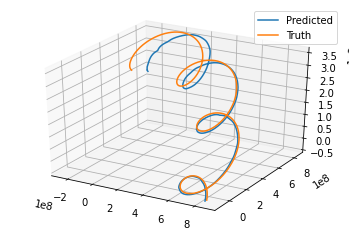

27.155309422169104

In [ ]:
opt_jup_model = transformed_fourier_nn(800)
opt_jup_model.fit(jup_data, d = 10, freq = 9.110526315789473e-08, plot = '3d')
opt_jup_model.predict(jup_validation, plot = '3d')

In [ ]:
#freqs = np.array([1.6657894736842106e-08])
#ds = np.linspace(2, 15, 14, dtype = int)

#hyperparameter_tune(freqs, ds, jup_data, jup_validation, declination = True)

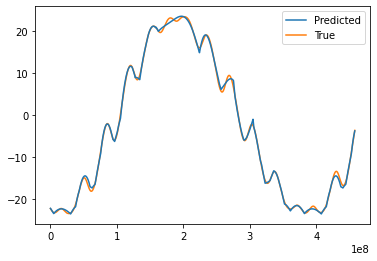

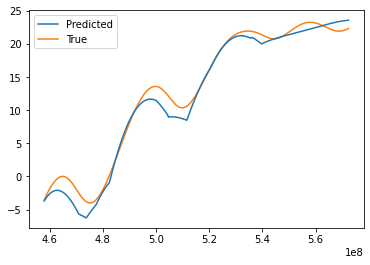

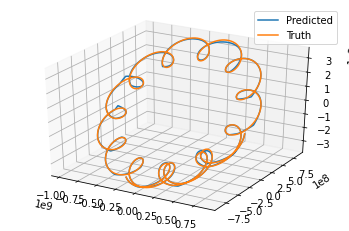

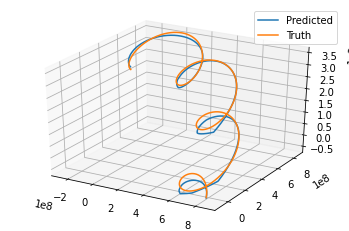

1.811432151757929

In [ ]:
optd_jup_model = fourier_nn().fit(jup_data, d = 6, freq = 1.6657894736842106e-08, silent = True, plot = 'd')
optd_jup_model.predict(jup_validation, plot = 'd')
optd_jup_model.predict(jup_data, plot = '3d')
optd_jup_model.predict(jup_validation, plot = '3d')

### Saturn:

In [ ]:
#freqs = np.array([7.4e-9])
#ds = np.linspace(2, 15, 14, dtype=int)

#hyperparameter_tune(freqs, ds, jup_data, jup_validation, time_delta=5000)

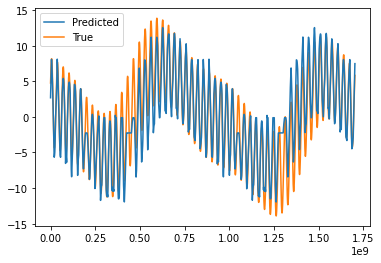

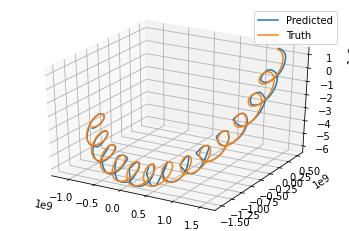

3.6801130556991786

In [ ]:
opt_sat_model = transformed_fourier_nn(5000)
opt_sat_model.fit(sat_data, d = 12, freq = 7.4e-9, plot = 't')
opt_sat_model.predict(sat_validation, plot = '3d')

In [ ]:
#freqs = np.array([3.3789473684210527e-09])
#ds = np.linspace(2, 15, 14, dtype = int)

#hyperparameter_tune(freqs, ds, sat_data, sat_validation, declination = True)

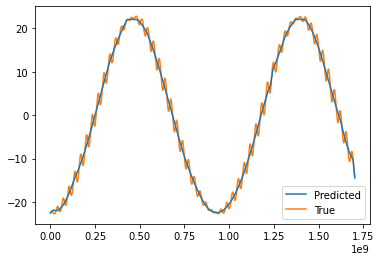

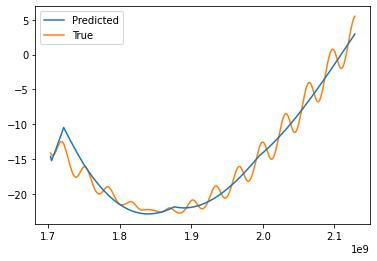

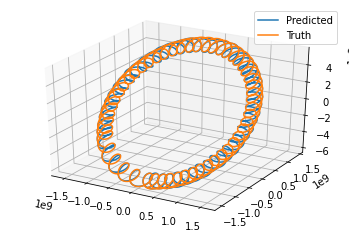

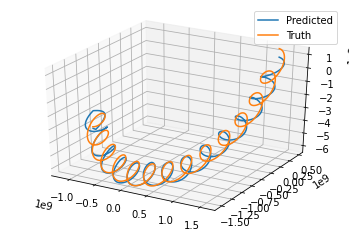

1.9154781506610905

In [ ]:
optd_sat_model = fourier_nn().fit(sat_data, d = 5, freq = 3.3789473684210527e-09, silent = True, plot = 'd')
optd_sat_model.predict(sat_validation, plot = 'd')
optd_sat_model.predict(sat_data, plot = '3d')
optd_sat_model.predict(sat_validation, plot = '3d')

### Uranus:

In [ ]:
#freqs = np.array([2.3368421052631577e-09])
#ds = np.linspace(2, 15, 14, dtype=int)

#hyperparameter_tune(freqs, ds, ura_data, ura_validation, time_delta = 7000)

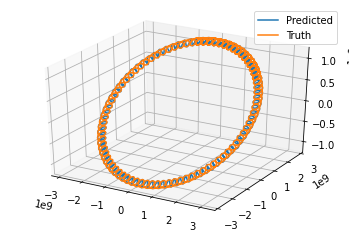

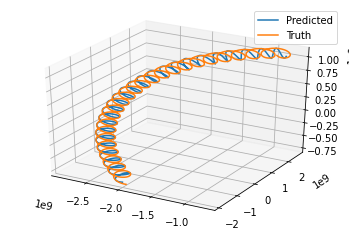

4.603512300396246

In [ ]:
opt_ura_model = transformed_fourier_nn(7000)
opt_ura_model.fit(ura_data, d= 12, freq = 2.3368421052631577e-09, plot = '3d')
opt_ura_model.predict(ura_validation, plot = '3d')

In [ ]:
#freqs = np.array([1.324736842105263e-09])
#ds = np.linspace(2, 15, 14, dtype = int)

#hyperparameter_tune(freqs, ds, ura_data, ura_validation, declination = True)

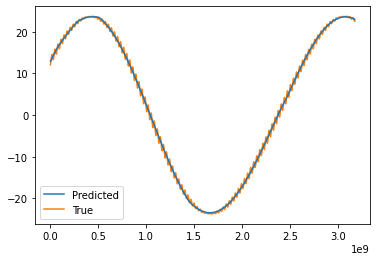

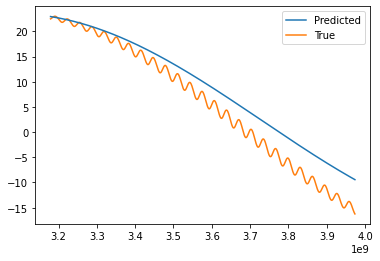

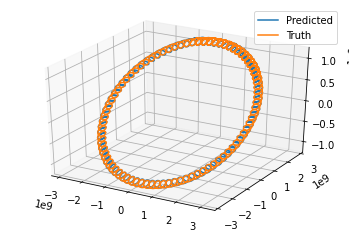

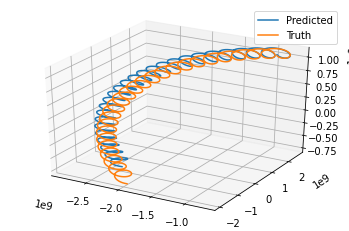

14.18341194336723

In [ ]:
optd_ura_model = fourier_nn().fit(ura_data, d = 3, freq = 1.201e-09, silent = True, plot = 'd')
optd_ura_model.predict(ura_validation, plot = 'd')
optd_ura_model.predict(ura_data, plot = '3d')
optd_ura_model.predict(ura_validation, plot = '3d')

### Neptune:

In [ ]:
#freqs = np.array([2.4473684210526316e-09])
#ds = np.linspace(2, 15, 14, dtype = int)

#hyperparameter_tune(freqs, ds, nep_data, nep_validation, time_delta = 20000)

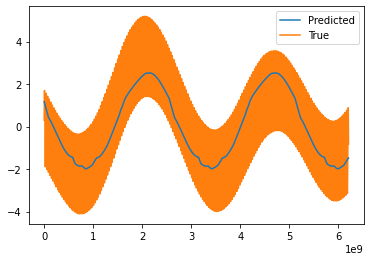

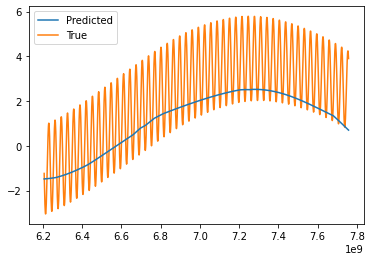

3.37228700273078

In [ ]:
opt_nep_model = transformed_fourier_nn(20000)
opt_nep_model.fit(nep_data, d= 3, freq = 2.4473684210526316e-09, plot = 't')
opt_nep_model.predict(nep_validation, plot = 't')

In [ ]:
#freqs = np.array([6.105263157894737e-10])
#ds = np.linspace(2, 15, 14, dtype = int)

#hyperparameter_tune(freqs, ds, nep_data, nep_validation, declination = True)

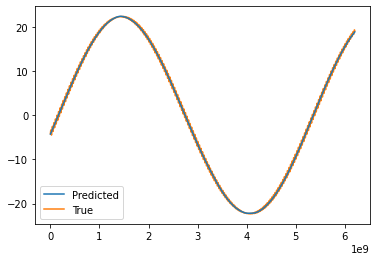

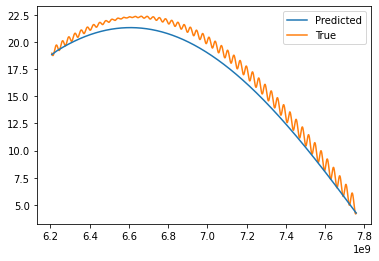

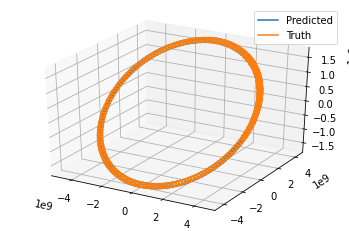

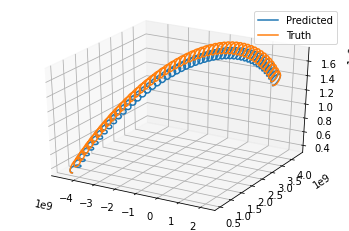

0.9424136831290799

In [ ]:
optd_nep_model = fourier_nn().fit(nep_data, d = 3, freq = 6.105263157894737e-10, silent = True, plot = 'd')
optd_nep_model.predict(nep_validation, plot = 'd')
optd_nep_model.predict(nep_data, plot = '3d')
optd_nep_model.predict(nep_validation, plot = '3d')

---
---
### Moon:

In [ ]:
#freqs = np.array([1.5157894736842105e-06])
#ds = np.linspace(2, 15, 14, dtype=int)

#hyperparameter_tune(freqs, ds, moon_data, moon_validation)

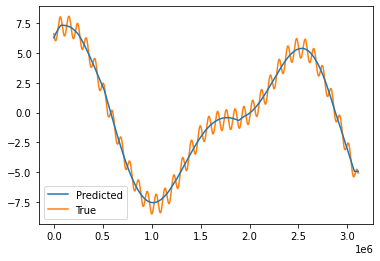

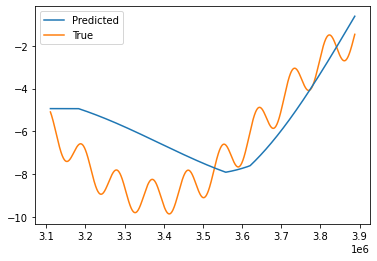

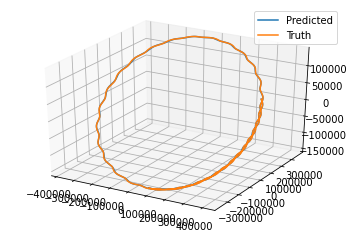

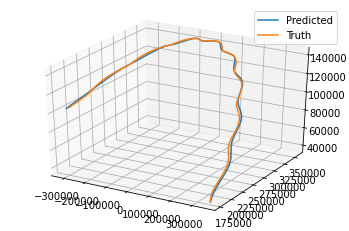

3.7087761464986495

In [ ]:
opt_moon_model = transformed_fourier_nn().fit(moon_data, d= 4, silent = True, freq = 1.5157894736842105e-06, plot = 't')
opt_moon_model.predict(moon_validation, plot = 't')
opt_moon_model.predict(moon_data, plot = '3d')
opt_moon_model.predict(moon_validation, plot = '3d')

In [ ]:
#freqs = np.array([2.6578947368421053e-06])
#ds = np.linspace(2, 15, 14, dtype = int)

#hyperparameter_tune(freqs, ds, moon_data, moon_validation, declination = True)

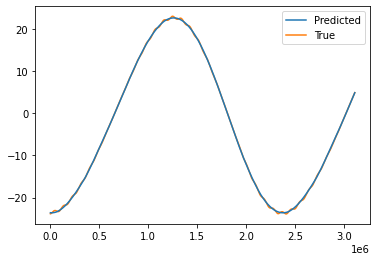

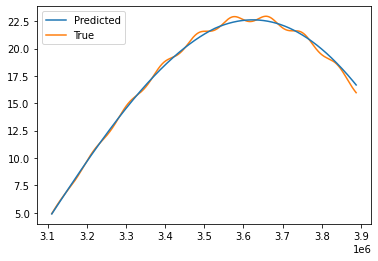

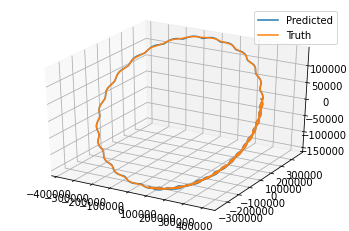

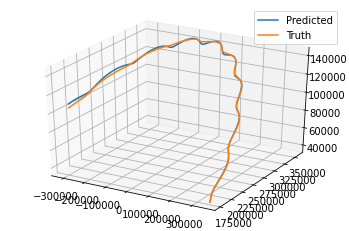

0.06084859147239705

In [ ]:
optd_moon_model = fourier_nn().fit(moon_data, d = 3, freq = 2.6578947368421053e-06, silent = True, plot = 'd')
optd_moon_model.predict(moon_validation, plot = 'd')
optd_moon_model.predict(moon_data, plot = '3d')
optd_moon_model.predict(moon_validation, plot = '3d')

### Sun:

In [ ]:
#freqs = np.array([1.4210526315789474e-07])
#ds = np.linspace(2, 15, 14, dtype=int)

#hyperparameter_tune(freqs, ds, sun_data, sun_validation)

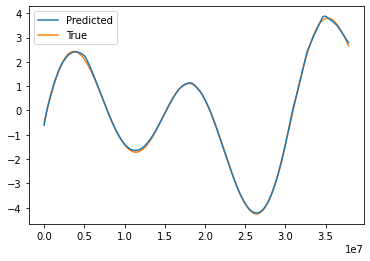

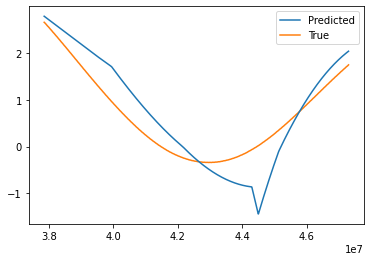

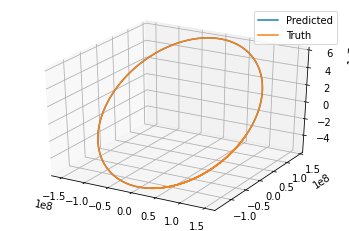

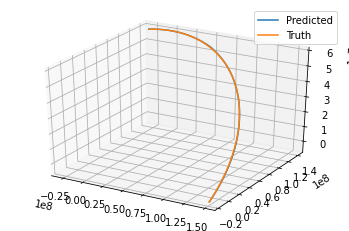

0.25958593465058777

In [ ]:
opt_sun_model = transformed_fourier_nn().fit(sun_data, d= 3, silent = True, freq = 1.4e-07, plot = 't')
opt_sun_model.predict(sun_validation, plot = 't')
opt_sun_model.predict(sun_data, plot = '3d')
opt_sun_model.predict(sun_validation, plot = '3d')

In [ ]:
#freqs = np.array([5.884210526315789e-08])
#ds = np.linspace(2, 15, 14, dtype = int)

#hyperparameter_tune(freqs, ds, sun_data, sun_validation, declination = True)

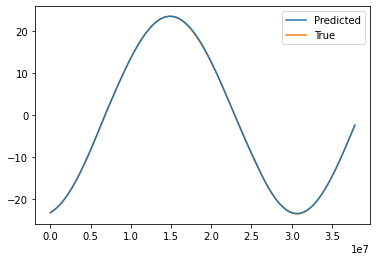

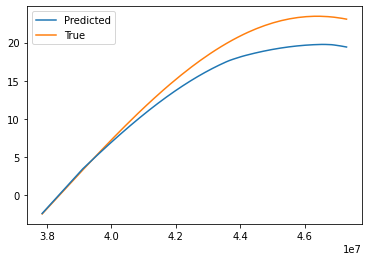

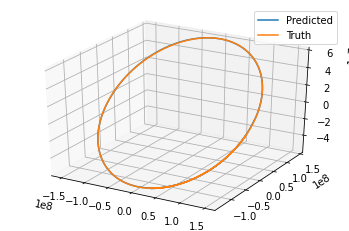

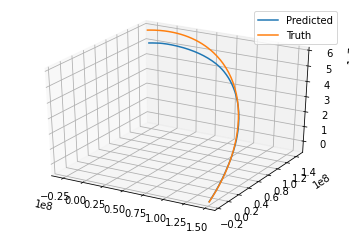

5.403221028168218

In [ ]:
optd_sun_model = fourier_nn().fit(sun_data, d = 5, freq = 5.87e-08, silent = True, plot = 'd')
optd_sun_model.predict(sun_validation, plot = 'd')
optd_sun_model.predict(sun_data, plot = '3d')
optd_sun_model.predict(sun_validation, plot = '3d')

# Testing:

In [ ]:
mer_test = mercury[int(train * len(mercury)):].reset_index()
ven_test = venus[int(train * len(venus)):].reset_index()
mars_test = mars[int(train * len(mars)):].reset_index()
jup_test = jupiter[int(train * len(jupiter)):].reset_index()
sat_test = saturn[int(train * len(saturn)):].reset_index()
ura_test = uranus[int(train * len(uranus)):].reset_index()
nep_test = neptune[int(train * len(neptune)):].reset_index()

sun_test = sun[int(train * len(sun)):].reset_index()
moon_test = moon[int(train * len(moon)):].reset_index()

Mercury
RMSE for RA: 8.68541073911962
RMSE for DECL: 3.7738672241204374
3D RMSE: 23949149.413468212


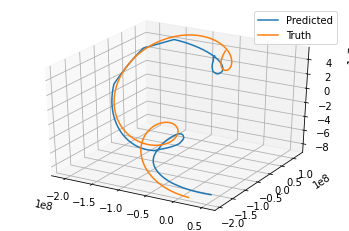

Venus
RMSE for RA: 8.635383776771347
RMSE for DECL: 8.96610381799705
3D RMSE: 36950289.553127125


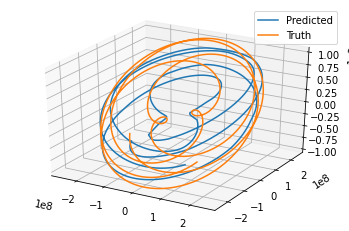

Mars
RMSE for RA: 12.53750740362006
RMSE for DECL: 10.997938781999114
3D RMSE: 44039771.01813177


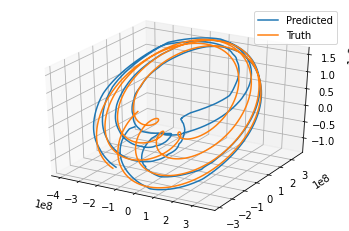

Jupiter
RMSE for RA: 6.457169291190987
RMSE for DECL: 1.1646113937462217
3D RMSE: 129773535.45576009


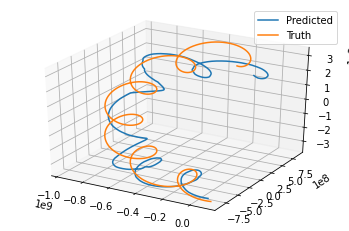

Saturn
RMSE for RA: 5.964978294467761
RMSE for DECL: 1.1672446906321134
3D RMSE: 140318287.9454121


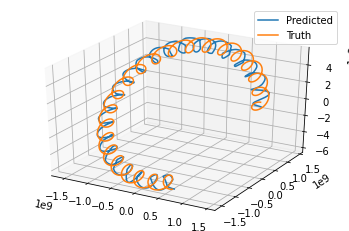

Uranus
RMSE for RA: 2.1980274281553998
RMSE for DECL: 4.722492351206929
3D RMSE: 262215800.65626788


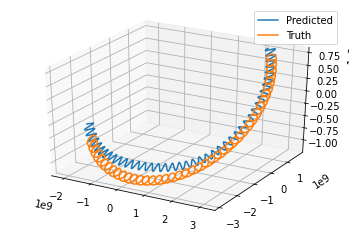

Neptune
RMSE for RA: 1.3577359481025117
RMSE for DECL: 2.6729033937941424
3D RMSE: 232471934.0203505


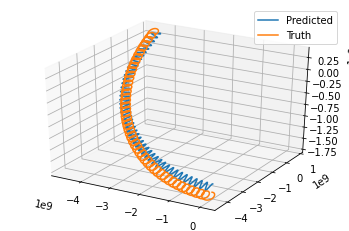

Sun
RMSE for RA: 1.0218943534320215
RMSE for DECL: 6.988459437531104
3D RMSE: 18178169.45788357


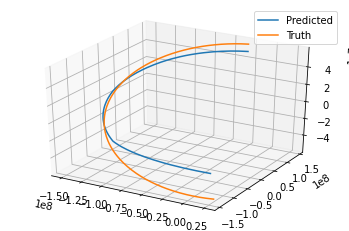

Moon
RMSE for RA: 6.637528752516442
RMSE for DECL: 0.34226663826072934
3D RMSE: 43226.51514570295


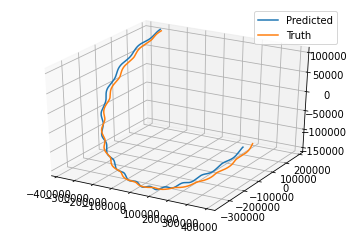

In [ ]:
### Mercury
print('Mercury')
mer_pred_ra, mse1 = opt_mer_model.predict(mer_test,return_val = True )
mer_pred_decl, mse2 = optd_mer_model.predict(mer_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(mer_pred_ra), np.radians(mer_pred_decl), mer_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(mer_test['Right Ascension']), np.radians(mer_test['Declination']), mer_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()
### Venus
print('Venus')
ven_pred_ra, mse1 = opt_ven_model.predict(ven_test,return_val = True )
ven_pred_decl, mse2 = optd_ven_model.predict(ven_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(ven_pred_ra), np.radians(ven_pred_decl), ven_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(ven_test['Right Ascension']), np.radians(ven_test['Declination']), ven_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()
### Mars
print('Mars')
mars_pred_ra, mse1 = opt_mars_model.predict(mars_test,return_val = True )
mars_pred_decl, mse2 = optd_mars_model.predict(mars_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(mars_pred_ra), np.radians(mars_pred_decl), mars_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(mars_test['Right Ascension']), np.radians(mars_test['Declination']), mars_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()
### Jupiter
print('Jupiter')
jup_pred_ra, mse1 = opt_jup_model.predict(jup_test,return_val = True )
jup_pred_decl, mse2 = optd_jup_model.predict(jup_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(jup_pred_ra), np.radians(mer_pred_decl), jup_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(jup_test['Right Ascension']), np.radians(jup_test['Declination']), jup_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()
### Saturn
print('Saturn')
sat_pred_ra, mse1 = opt_sat_model.predict(sat_test,return_val = True )
sat_pred_decl, mse2 = optd_sat_model.predict(sat_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(sat_pred_ra), np.radians(sat_pred_decl), sat_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(sat_test['Right Ascension']), np.radians(sat_test['Declination']), sat_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()
### Uranus
print('Uranus')
ura_pred_ra, mse1 = opt_ura_model.predict(ura_test,return_val = True )
ura_pred_decl, mse2 = optd_ura_model.predict(ura_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(ura_pred_ra), np.radians(ura_pred_decl), ura_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(ura_test['Right Ascension']), np.radians(ura_test['Declination']), ura_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()
### Neptune
print('Neptune')
nep_pred_ra, mse1 = opt_nep_model.predict(nep_test,return_val = True )
nep_pred_decl, mse2 = optd_nep_model.predict(nep_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(nep_pred_ra), np.radians(nep_pred_decl), nep_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(nep_test['Right Ascension']), np.radians(nep_test['Declination']), nep_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()
### Sun
print('Sun')
sun_pred_ra, mse1 = opt_sun_model.predict(sun_test,return_val = True )
sun_pred_decl, mse2 = optd_sun_model.predict(sun_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(sun_pred_ra), np.radians(sun_pred_decl), sun_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(sun_test['Right Ascension']), np.radians(sun_test['Declination']), sun_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()
### Moon
print('Moon')
moon_pred_ra, mse1 = opt_moon_model.predict(moon_test,return_val = True )
moon_pred_decl, mse2 = optd_moon_model.predict(moon_test, return_val = True)
print('RMSE for RA: ' + str(np.sqrt(mse1)))
print('RMSE for DECL: ' + str(np.sqrt(mse2)))
x1, y1, z1 = convert_cartesian(np.radians(moon_pred_ra), np.radians(moon_pred_decl), moon_test['Distance'])
x2, y2, z2 = convert_cartesian(np.radians(moon_test['Right Ascension']), np.radians(moon_test['Declination']), moon_test['Distance'])
mse3 = np.mean((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
print('3D RMSE: ' + str(np.sqrt(mse3)))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)
plt.legend(['Predicted', 'Truth'])
plt.show()

# Serializing Models for Use in Master Notebook (ignore)

In [ ]:
import pickle
#Right Ascension Models

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/nn_mer.sav'
pickle.dump(opt_mer_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/nn_ven.sav'
pickle.dump(opt_ven_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/nn_mars.sav'
pickle.dump(opt_mars_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/nn_jup.sav'
pickle.dump(opt_jup_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/nn_sat.sav'
pickle.dump(opt_sat_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/nn_ura.sav'
pickle.dump(opt_ura_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/nn_nep.sav'
pickle.dump(opt_nep_model, open(filename, 'wb'))

#Declination models


filename = '/drive/My Drive/EECS189/PROJ S/Pickles/nn_merd.sav'
pickle.dump(optd_mer_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/nn_vend.sav'
pickle.dump(optd_ven_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/nn_marsd.sav'
pickle.dump(optd_mars_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/nn_jupd.sav'
pickle.dump(optd_jup_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/nn_satd.sav'
pickle.dump(optd_sat_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/nn_urad.sav'
pickle.dump(optd_ura_model, open(filename, 'wb'))

filename = '/drive/My Drive/EECS189/PROJ S/Pickles/nn_nepd.sav'
pickle.dump(optd_nep_model, open(filename, 'wb'))